In [1]:
# %pip install scikit-learn
#%pip install pandas torch torchvision torchaudio


In [6]:
import numpy as np

# Function to convert sequence to pairings
def convert_to_pairings(seq):
    # seq = seq[0]
    result = []

    AT_pair = []
    TA_pair = []
    CG_pair = []
    GC_pair = []
    unpaired = []

    for i in range(len(seq)):
        # base pairings
        AT_pair_row = [0] * len(seq)
        TA_pair_row = [0] * len(seq)
        CG_pair_row = [0] * len(seq)
        GC_pair_row = [0] * len(seq)
        unpaired_row = [1] * len(seq)

        for j in range(len(seq)):
            if (seq[i] == 'A' and seq[j] == 'T'):
                AT_pair_row[j] = 1
                unpaired_row[j] = 1
            elif (seq[i] == 'T' and seq[j] == 'A'):
                TA_pair_row[j] = 1
                unpaired_row[j] = 1
            elif (seq[i] == 'C' and seq[j] == 'G'):
                CG_pair_row[j] = 1
                unpaired_row[j] = 1
            elif (seq[i] == 'G' and seq[j] == 'C'):
                GC_pair_row[j] = 1
                unpaired_row[j] = 0

        AT_pair.append(AT_pair_row)
        TA_pair.append(TA_pair_row)
        CG_pair.append(CG_pair_row)
        GC_pair.append(GC_pair_row)
        unpaired.append(unpaired_row)

    result.append(AT_pair)
    result.append(TA_pair)
    result.append(CG_pair)
    result.append(GC_pair)
    result.append(unpaired)

    return np.array(result)

def convert_to_pairings_dataset(dataset):
    result = []
    for seq in dataset:
        result.append(convert_to_pairings(seq))
    return result


def structure_to_matrix(structure):
    length = len(structure)
    matrix = np.zeros((length, length))
    stack = []

    for i, symbol in enumerate(structure):
        if symbol == '(':
            stack.append(i)
        elif symbol == ')':
            j = stack.pop()
            matrix[i][j] = 1
            matrix[j][i] = 1

    return matrix


In [7]:
import pandas as pd
import numpy as np

# Load the .pkl file
file_path = 'train_250k_struct.pkl'
data = pd.read_pickle(file_path)

subset = data.dataset[:100000]

# Assuming 'data' is a list of tuples with the format: (sequence, numerical value, structure string, other info)
# Extract sequences and numerical values as separate lists

dataset_X = np.array([item[0] for item in subset])  # Sequences
dataset_Y =  np.array([item[1] for item in subset])  # Numerical values
structures =  [structure_to_matrix(item[2]) for item in subset]  # Structural strings

# Convert dataset_X to pairings
dataset_X = convert_to_pairings_dataset(dataset_X)

# Convert dataset_X and dataset_Y into numpy arrays if not already
dataset_X = dataset_X
dataset_Y = np.array(dataset_Y, dtype=float)

In [8]:
from sklearn.model_selection import train_test_split

#split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(dataset_X, structures, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
#print(X_train.shape[1])

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(5, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((10, 10))  # output size of 10x10
        self.fc1 = nn.Linear(64 * 10 * 10, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.adaptive_pool(x)  # Adaptive pooling layer
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class StructureCNN(nn.Module):
    def __init__(self, num_channels, output_size):
        super(StructureCNN, self).__init__()
        self.output_size = output_size
        self.conv1 = nn.Conv2d(num_channels, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.adaptive_pool = nn.AdaptiveAvgPool2d((self.output_size, self.output_size))
        self.fc1 = nn.Linear(64 * self.output_size * self.output_size, 512)
        self.fc2 = nn.Linear(512, self.output_size * self.output_size)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.view(-1, self.output_size, self.output_size)
        x = torch.sigmoid(x)
        return x

def pad_structure(matrix, common_size, num_channels=None):
    if num_channels:
        padded_matrix = np.zeros((num_channels, *common_size))
        for i in range(num_channels):
            padded_matrix[i, :matrix.shape[1], :matrix.shape[2]] = matrix[i]
    else:
        padded_matrix = np.zeros(common_size)
        padded_matrix[:matrix.shape[0], :matrix.shape[1]] = matrix
    return padded_matrix


# Pad and convert X_train and y_train to tensors
common_size = (50, 50)  # based on the longest sequence in dataset

X_train_padded = [pad_structure(x, common_size, 5) for x in X_train]
# No padding if predicting mfe
y_train_padded = [pad_structure(y, common_size) for y in y_train]

X_train_tensors = [torch.tensor(x, dtype=torch.float32) for x in X_train_padded]
y_train_tensors = [torch.tensor(y, dtype=torch.float32) for y in y_train_padded]

# y_train_tensors = torch.tensor(y_train, dtype=torch.float32)

dataset = [(x, y) for x, y in zip(X_train_tensors, y_train_tensors)]

X_val_padded = [pad_structure(x, common_size, 5) for x in X_val]
X_val_tensors = [torch.tensor(x, dtype=torch.float32) for x in X_val_padded]
# y_val_tensors = torch.tensor(y_val, dtype=torch.float32)
y_val_padded = [pad_structure(y, common_size) for y in y_val]
y_val_tensors = [torch.tensor(y, dtype=torch.float32) for y in y_val_padded]

val_dataset = [(x, y) for x, y in zip(X_val_tensors, y_val_tensors)]

# DataLoader setup
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# model = SimpleCNN()
model = StructureCNN(num_channels=5, output_size=50)

criterion = nn.BCELoss()
# criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
# Training loop with validation
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    sum_loss = 0
    for inputs, labels in dataloader:
        # Forward pass
        outputs = model(inputs)
        # loss = criterion(outputs, labels.unsqueeze(1))
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()

    average_loss = sum_loss / len(dataloader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {average_loss:.6f}', end='')

    # Validation loss calculation
    model.eval()
    with torch.no_grad():
        val_loss = 0
        for inputs, labels in val_dataloader:
            outputs = model(inputs)
            # loss = criterion(outputs, labels.unsqueeze(1))
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        average_val_loss = val_loss / len(val_dataloader.dataset)
        print(f', Validation Loss: {average_val_loss:.6f}')
    losses.append((average_loss, average_val_loss))



Epoch [1/100], Average Loss: 0.000487, Validation Loss: 0.000319
Epoch [2/100], Average Loss: 0.000272, Validation Loss: 0.000297
Epoch [3/100], Average Loss: 0.000180, Validation Loss: 0.000336
Epoch [4/100], Average Loss: 0.000096, Validation Loss: 0.000389
Epoch [5/100], Average Loss: 0.000066, Validation Loss: 0.000451
Epoch [6/100], Average Loss: 0.000045, Validation Loss: 0.000557
Epoch [7/100], Average Loss: 0.000033, Validation Loss: 0.000593
Epoch [8/100], Average Loss: 0.000024, Validation Loss: 0.000651
Epoch [9/100], Average Loss: 0.000021, Validation Loss: 0.000736


In [16]:
# model = SimpleCNN()

# # Load the saved model weights
# model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

Test Loss: 0.0227
MAE: 0.6411
R^2: 0.8033


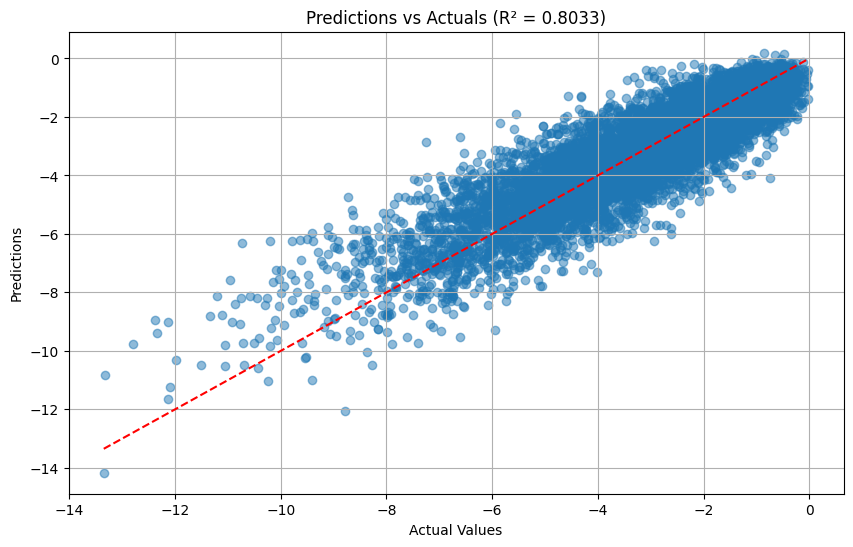

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

model.eval()

X_test_padded = [pad_structure(x, common_size, 5) for x in X_test]
X_test_tensors = [torch.tensor(x, dtype=torch.float32) for x in X_test_padded]

# No padding if predicting mfe
y_test_padded = [pad_structure(y, common_size) for y in y_train]
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
y_test_tensor = [torch.tensor(y, dtype=torch.float32) for y in y_test_padded]

# DataLoader for the test set
test_dataset = [(x, y) for x, y in zip(X_test_tensors, y_test_tensor)]

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


test_loss_sum = 0
mae_sum = 0

predictions = []
actuals = []

# No need to track gradients for testing
with torch.no_grad():
    for x_tensor, y_tensor in test_dataloader:
        output = model(x_tensor)  # x_tensor already has a batch dimension from the DataLoader
        loss = criterion(output, y_tensor.unsqueeze(1))

        test_loss_sum += loss.item()

        # Calculate MAE for the batch and add to the total MAE sum
        mae = torch.mean(torch.abs(output.squeeze() - y_tensor))
        mae_sum += mae.item() * x_tensor.size(0)

        predictions.extend(output.squeeze().tolist())  # Flatten and add to predictions list
        actuals.extend(y_tensor.tolist())  # Flatten and add to actuals list

# Calculate the average test loss
average_test_loss = test_loss_sum / len(test_dataloader.dataset)
average_mae = mae_sum / len(test_dataloader.dataset)

print(f'Test Loss: {average_test_loss:.4f}')
print(f'MAE: {average_mae:.4f}')

# Calculate R-squared value
r_squared = r2_score(actuals, predictions)
print(f'R^2: {r_squared:.4f}')

# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(actuals, predictions, alpha=0.5)
plt.title(f'Predictions vs Actuals (R² = {r_squared:.4f})')
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--')  # Diagonal line for reference
plt.show()

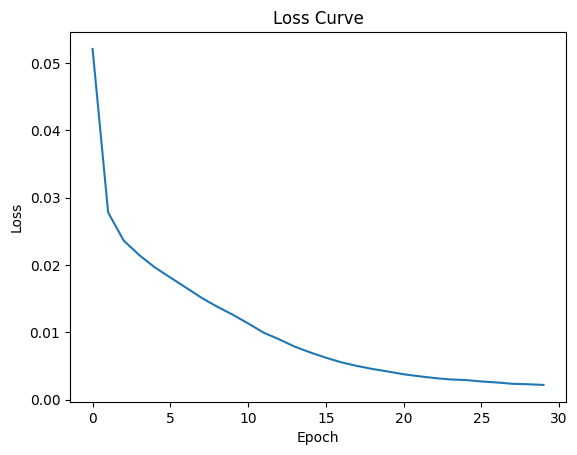

In [11]:

import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()


In [12]:
torch.save(model.state_dict(), 'model.pth')